<a href="https://colab.research.google.com/github/kystoq/workshop_transformacja-3/blob/master/matrix3_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd "/content/drive/My Drive/Colab Notebooks/matrix/matrix3/workshop_transformacja-3"

/content/drive/My Drive/Colab Notebooks/matrix/matrix3/workshop_transformacja-3


In [2]:
!ls data

dw_signnames  test_road_sign  train_road_sign


In [25]:
import pandas as pd
import numpy as np
import os
import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from skimage import color, exposure

from sklearn.metrics import accuracy_score

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
train = pd.read_pickle('data/train_road_sign')
test = pd.read_pickle('data/test_road_sign')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [37]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((34799, 32, 32, 3), (34799,), (4410, 32, 32, 3), (4410,))

In [0]:
if y_train.ndim == 1:
  y_train = to_categorical(y_train)
if y_test.ndim == 1:
  y_test = to_categorical(y_test)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
  ])

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  logdir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  model.fit(
      X_train,
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      # validation_data=params_fit.get('validation_data', (X_test, y_test)),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensorboard_callback]
  )

  return model

In [43]:
model_trained = train_model(get_cnn_v1(input_shape, num_classes), X_train, y_train)

Epoch 1/5
272/272 [==============================] - 2s 7ms/step - loss: 32.3304 - accuracy: 0.7127 - val_loss: 2.0084 - val_accuracy: 0.7565
Epoch 2/5
272/272 [==============================] - 2s 6ms/step - loss: 0.2448 - accuracy: 0.9449 - val_loss: 2.5650 - val_accuracy: 0.7730
Epoch 3/5
272/272 [==============================] - 2s 6ms/step - loss: 0.1461 - accuracy: 0.9690 - val_loss: 2.3121 - val_accuracy: 0.8048
Epoch 4/5
272/272 [==============================] - 2s 6ms/step - loss: 0.1324 - accuracy: 0.9716 - val_loss: 2.4748 - val_accuracy: 0.7912
Epoch 5/5
272/272 [==============================] - 2s 6ms/step - loss: 0.1283 - accuracy: 0.9730 - val_loss: 2.7549 - val_accuracy: 0.8145


In [15]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob

array([[2.3638552e-12, 9.0268250e-06, 3.2777989e-05, ..., 1.5173600e-03,
        1.3660575e-01, 7.8766001e-03],
       [4.7879173e-10, 4.5860223e-05, 5.5134518e-04, ..., 2.3662942e-02,
        7.7428739e-03, 1.0516584e-03],
       [2.0118774e-12, 1.2311618e-05, 8.6854209e-07, ..., 1.4086836e-04,
        4.6997990e-02, 3.0842414e-03],
       ...,
       [2.3595124e-02, 4.1731976e-02, 1.9475037e-02, ..., 2.3916843e-03,
        9.4964821e-03, 5.9657181e-03],
       [9.7305197e-03, 2.0732274e-02, 1.5793946e-02, ..., 5.0090295e-03,
        7.4649327e-03, 4.6238359e-03],
       [1.4090725e-02, 2.9760789e-02, 1.6725985e-02, ..., 2.5539666e-03,
        6.6467780e-03, 4.6032513e-03]], dtype=float32)

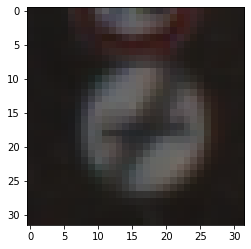

In [17]:
plt.imshow(X_train[0])

In [19]:
y_pred_prob[0]
np.argmax(y_pred_prob[0])

9

<BarContainer object of 43 artists>

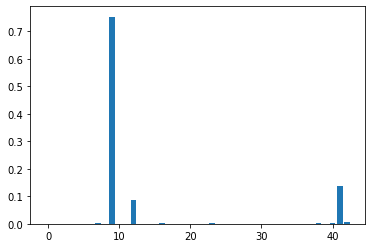

In [24]:
plt.bar(range(43), y_pred_prob[0])

In [0]:
df = pd.read_csv('data/dw_signnames')
labels_dict = df.to_dict()['b']

In [21]:
labels_dict[9]

'No passing'

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [51]:
predict(model_trained, X_test, y_test)

0.8145124716553288

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [53]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v2(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 2s 7ms/step - loss: 3.9995 - accuracy: 0.4808 - val_loss: 0.8233 - val_accuracy: 0.7816
Epoch 2/5
272/272 [==============================] - 2s 6ms/step - loss: 0.6264 - accuracy: 0.8213 - val_loss: 0.4180 - val_accuracy: 0.8873
Epoch 3/5
272/272 [==============================] - 2s 6ms/step - loss: 0.3675 - accuracy: 0.8926 - val_loss: 0.3414 - val_accuracy: 0.9111
Epoch 4/5
272/272 [==============================] - 2s 7ms/step - loss: 0.2627 - accuracy: 0.9215 - val_loss: 0.2990 - val_accuracy: 0.9322
Epoch 5/5
272/272 [==============================] - 2s 7ms/step - loss: 0.2165 - accuracy: 0.9361 - val_loss: 0.2552 - val_accuracy: 0.9374


0.9374149659863945

In [54]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),


    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v3(input_shape, num_classes))

Epoch 1/5
272/272 [==============================] - 3s 9ms/step - loss: 2.0625 - accuracy: 0.5751 - val_loss: 0.4540 - val_accuracy: 0.8916
Epoch 2/5
272/272 [==============================] - 2s 9ms/step - loss: 0.4215 - accuracy: 0.8782 - val_loss: 0.2712 - val_accuracy: 0.9372
Epoch 3/5
272/272 [==============================] - 2s 9ms/step - loss: 0.2753 - accuracy: 0.9196 - val_loss: 0.1829 - val_accuracy: 0.9580
Epoch 4/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1995 - accuracy: 0.9396 - val_loss: 0.1366 - val_accuracy: 0.9689
Epoch 5/5
272/272 [==============================] - 2s 9ms/step - loss: 0.1504 - accuracy: 0.9546 - val_loss: 0.1774 - val_accuracy: 0.9651


0.9650793650793651

In [59]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v4(input_shape, num_classes))
# get_cnn_v4(input_shape, num_classes).summary()

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 2.4024 - accuracy: 0.3642 - val_loss: 0.9312 - val_accuracy: 0.7420
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 0.7629 - accuracy: 0.7688 - val_loss: 0.4053 - val_accuracy: 0.8864
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3839 - accuracy: 0.8853 - val_loss: 0.1998 - val_accuracy: 0.9456
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2635 - accuracy: 0.9199 - val_loss: 0.1311 - val_accuracy: 0.9633
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.1982 - accuracy: 0.9393 - val_loss: 0.1234 - val_accuracy: 0.9651


0.9650793650793651

In [60]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

train_and_predict(get_cnn_v5(input_shape, num_classes))
# get_cnn_v5(input_shape, num_classes).summary()

Epoch 1/5
272/272 [==============================] - 3s 11ms/step - loss: 2.7407 - accuracy: 0.2571 - val_loss: 1.3707 - val_accuracy: 0.5712
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 1.0701 - accuracy: 0.6527 - val_loss: 0.4573 - val_accuracy: 0.8703
Epoch 3/5
272/272 [==============================] - 3s 10ms/step - loss: 0.5351 - accuracy: 0.8298 - val_loss: 0.2214 - val_accuracy: 0.9417
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.3448 - accuracy: 0.8942 - val_loss: 0.1408 - val_accuracy: 0.9621
Epoch 5/5
272/272 [==============================] - 3s 10ms/step - loss: 0.2447 - accuracy: 0.9255 - val_loss: 0.1202 - val_accuracy: 0.9664


0.9664399092970521

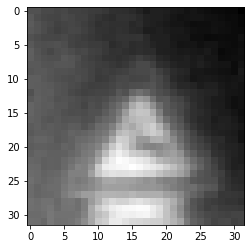

In [63]:
plt.imshow(color.rgb2gray(X_train[400]), cmap=plt.get_cmap('gray'))

In [65]:
color.rgb2gray(X_train).shape, color.rgb2gray(X_test).shape

((34799, 32, 32), (4410, 32, 32))

In [68]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

ERROR! Session/line number was not unique in database. History logging moved to new session 62


In [71]:
model = get_cnn_v5((32, 32, 1), num_classes)
model_trained_gray = train_model(model, X_train_gray, y_train)
predict(model_trained_gray, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 4s 15ms/step - loss: 2.3714 - accuracy: 0.3260 - val_loss: 0.5862 - val_accuracy: 0.8043
Epoch 2/5
272/272 [==============================] - 4s 14ms/step - loss: 0.5240 - accuracy: 0.8265 - val_loss: 0.1372 - val_accuracy: 0.9555
Epoch 3/5
272/272 [==============================] - 4s 14ms/step - loss: 0.2372 - accuracy: 0.9252 - val_loss: 0.0563 - val_accuracy: 0.9829
Epoch 4/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1438 - accuracy: 0.9539 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 5/5
272/272 [==============================] - 4s 14ms/step - loss: 0.1114 - accuracy: 0.9657 - val_loss: 0.0204 - val_accuracy: 0.9936


0.963718820861678